In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mutual_info_score
from sklearn.feature_selection import mutual_info_regression

In [3]:
data = pd.read_csv('data.csv', delimiter=';')
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,16,U,LE3,T,4,3,teacher,services,...,5,4,3,1,2,1,2,16,15,15
1,GP,M,18,U,LE3,T,1,1,other,other,...,2,3,5,2,5,4,0,6,5,0
2,GP,M,17,R,LE3,A,4,4,teacher,other,...,3,3,3,2,3,4,2,10,11,12
3,GP,F,15,U,LE3,T,3,2,services,other,...,4,4,4,1,1,5,10,7,6,6
4,GP,M,16,U,GT3,T,2,3,other,other,...,5,3,3,1,1,3,0,13,14,14


In [4]:
# check for duplicates and nulls 

print(data.isna().any().sum()) # 0 null values 
data.drop_duplicates()
print(data.shape) # no duplicates

0
(316, 33)


In [5]:
data.dtypes
cat = data.select_dtypes(include ="object")
print(cat.shape)
num = data.select_dtypes('int')
print(num.shape)


(316, 17)
(316, 16)


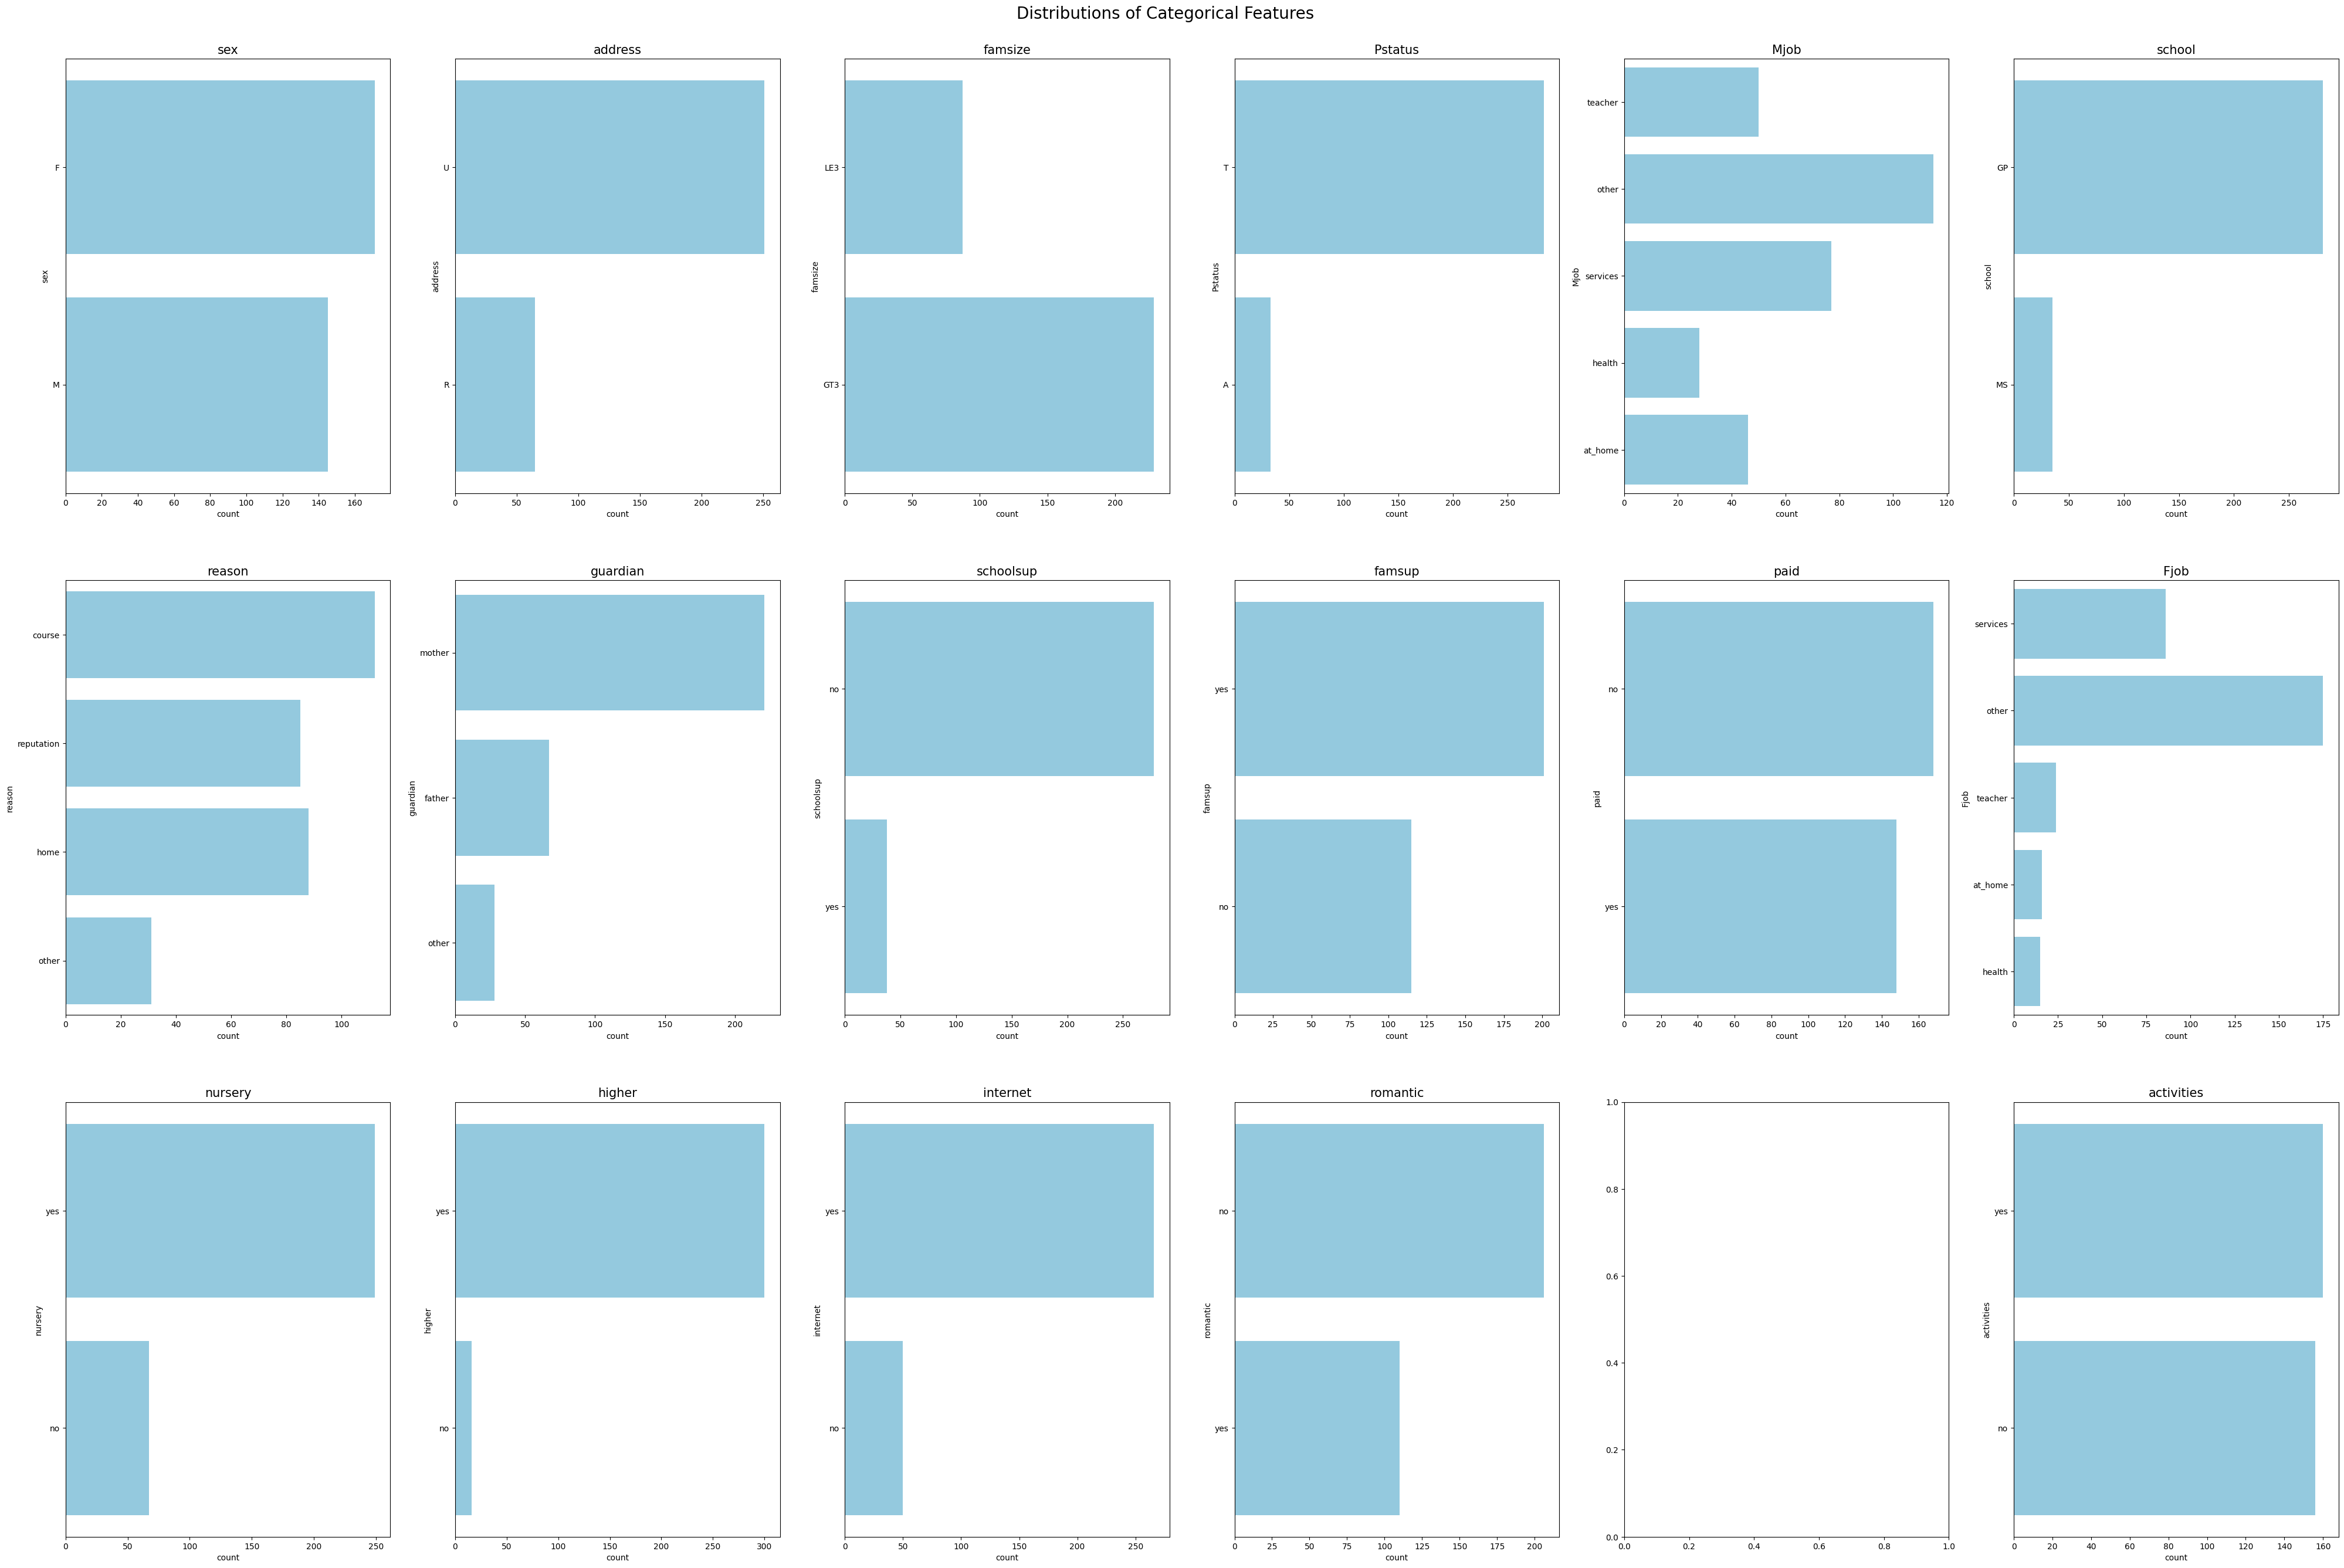

In [6]:
#plot  distributions of categorical data
fig, ax = plt.subplots(3,6, figsize = (50,30))
for i in range(17):
    if i < 6:
        row = 0
    elif i > 11:
        row = 2
    else: row = 1
    col = i % 6 - 1
    sns.countplot(cat[cat.columns[i]], ax= ax[row,col], color = 'skyblue')
    ax[row,col].set_title(cat.columns[i], fontsize = 15)
plt.suptitle("Distributions of Categorical Features", fontsize = 20)
plt.subplots_adjust(top = .95)

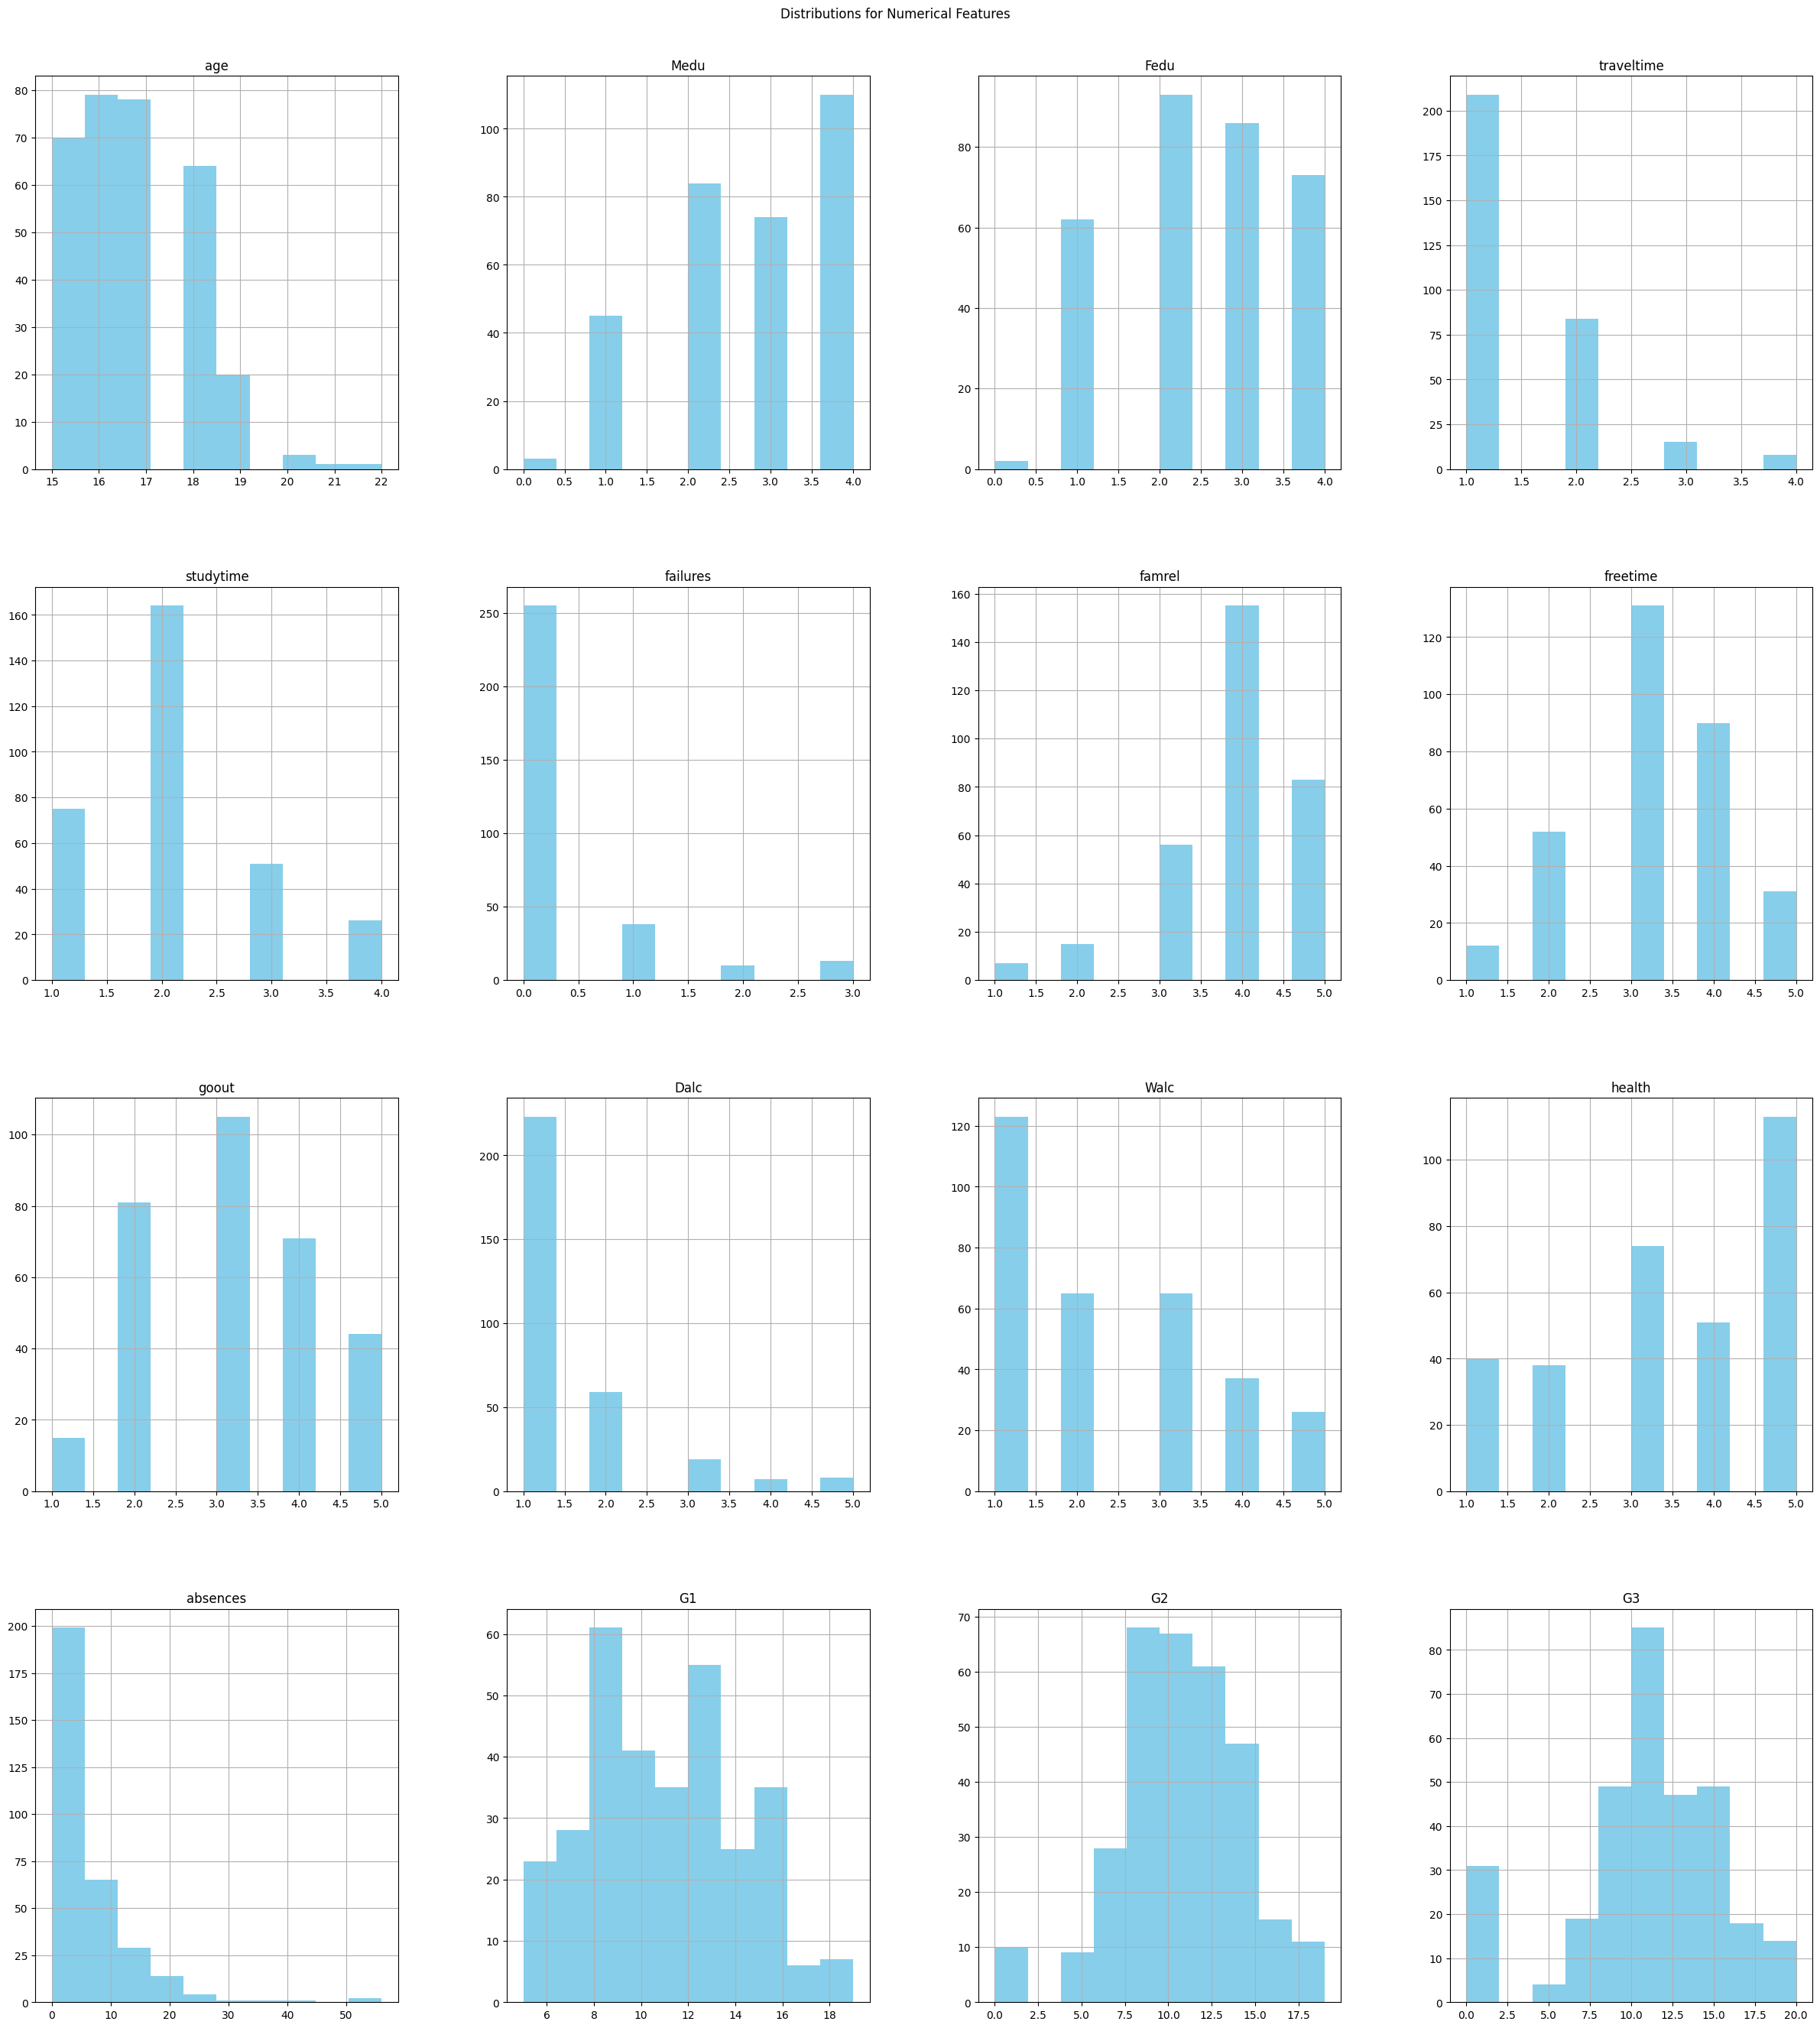

In [7]:
#distributions of numerical features
num.hist(color = 'skyblue', bins = 10, figsize = (30,30))
plt.suptitle("Distributions for Numerical Features")
plt.subplots_adjust(top = 0.95)

In [8]:
#encoding data for MI exploration
data['school'] = [0 if x == "GP" else 1 for x in data['school']]
data['address'] = [0 if x == "U" else 1 for x in data['address']] #encode numerically -- 0 is urben, 1 is rural
data['Pstatus'] = [0 if x == "A" else 1 for x in data['Pstatus']] #0 is apart, 1 is together
data['famsize'] = [0 if x == "LE3" else 1 for x in data['famsize']] #0 is less than 3, 1 is greater than 3 
data['sex'] = [0 if x == "M" else 1 for x in data['sex']] #0 is M, 1 is F
data['Mjob'] = [0 if x == "teacher" else 1 if x == "health" else 2 if x == "services" else 3 if x == "at_home" else 4 for x in data['Mjob']]
data['Fjob'] = [0 if x == "teacher" else 1 if x == "health" else 2 if x == "services" else 3 if x == "at_home" else 4 for x in data['Fjob']]
data['reason'] = [0 if x == "home" else 1 if x == "school" else 2 if x == "course" else 3 for x in data['reason']]
data['guardian'] = [0 if x == "mother" else 1 if x == "father" else 2 for x in data['guardian']]

data.replace({'schoolsup' : {'yes': 1, "no" : 0}, 'famsup' : {'yes': 1, "no" : 0}, 'paid' :  {'yes': 1, "no" : 0}, 'activities' :  {'yes': 1, "no" : 0}, 'nursery':  {'yes': 1, "no" : 0}, 'higher':  {'yes': 1, "no" : 0}, 'internet':  {'yes': 1, "no" : 0}, 'romantic':  {'yes': 1, "no" : 0}}, inplace= True)
print(data['schoolsup'])
print(data.shape)
data.head()



0      0
1      0
2      0
3      0
4      0
      ..
311    0
312    1
313    0
314    0
315    1
Name: schoolsup, Length: 316, dtype: int64
(316, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,1,16,0,0,1,4,3,0,2,...,5,4,3,1,2,1,2,16,15,15
1,0,0,18,0,0,1,1,1,4,4,...,2,3,5,2,5,4,0,6,5,0
2,0,0,17,1,0,0,4,4,0,4,...,3,3,3,2,3,4,2,10,11,12
3,0,1,15,0,0,1,3,2,2,4,...,4,4,4,1,1,5,10,7,6,6
4,0,0,16,0,1,1,2,3,4,4,...,5,3,3,1,1,3,0,13,14,14


In [9]:
#histograms for data distribution

'''Notes:
- most students go to MS 
- no students chose reason as school reputation, need to drop during encoding 
-exponential distribution of absences -- maybe take log? 
'''

'Notes:\n- most students go to MS \n- no students chose reason as school reputation, need to drop during encoding \n-exponential distribution of absences -- maybe take log? \n'

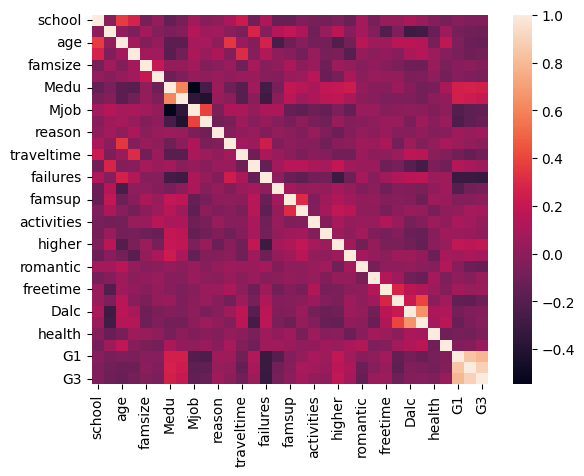

In [23]:
#correlation matrix -- not very helpful with so many nominal features 
corr_matrix = data.corr()
plt.plot(figsize = (20,20))
sns.heatmap(corr_matrix)
plt.savefig('figures/correlation_heatmap.png', bbox_inches = 'tight')

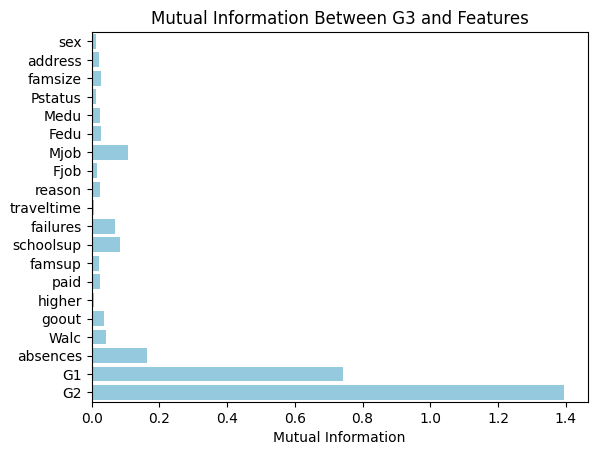

In [22]:
#mutual information-- overall, G1 and G2 have the highest MI scores by a large margin 
''' these features had an MI of 0 (but might have to do with encoding 
sex: 0.0 
age: 0.0 
address: 0.0 
Mjob: 0.0 
Fjob: 0.0 
reason: 0.0 
studytime: 0.0 
famrel: 0.0 
freetime: 0.0 '''
X = data.drop('G3', axis = 1)
X.head()
mi = mutual_info_regression(X, data['G3'])
temp_col = list(X.columns)
temp_mi = list(mi.copy())

mask = [x != 0 for x in temp_mi]
temp_mi = [x for x, m in zip(temp_mi, mask) if m]
temp_col = [x for x, m in zip(temp_col, mask) if m]
# i = 0
# while i < range(len(temp_mi))
#     if mi[i] == 0:
#         print(f"{X.columns[i]}: {mi[i]} ")
#         temp.pop(i)
#         temp_mi.pop(i)


sns.barplot(y = temp_col, x= temp_mi, color = 'skyblue')
plt.title("Mutual Information Between G3 and Features")
plt.ylabel('')
plt.xlabel('Mutual Information')
plt.savefig('figures/mutual_info.png', bbox_inches='tight')
